In [6]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas
import math

# make this point to the file with the clean tweets
DATAFILE = "data_clean_stemmed_withoutRT.csv"
# make this point to the file with the text tweets
TWEETSFILE = "data_original_notStemmed_withoutRT.csv"

In [2]:
# import the tweets
text_tweets = pandas.read_csv(TWEETSFILE, index_col=0)
# read the csv
data = pandas.read_csv(DATAFILE, index_col=0)
# get all the tweets
# as of now, they are still strings, the string representation of the list
tweets = []
for tweet in data["text"]:
    tweets.append(eval(tweet))
    
# find all unique words and count them
uniqueWords = {}
total_words = 0
for tweet in tweets:
    for word in tweet:
        total_words += 1
        if word in uniqueWords.keys():
            uniqueWords[word] += 1
        else:
            uniqueWords[word] = 1
print(f"We have {total_words} words, of which {len(uniqueWords.keys())} are unique")
words_tuples = [(word, uniqueWords[word]) for word in uniqueWords.keys()]
words_tuples.sort(reverse=True, key=lambda t: t[1])
print(words_tuples[0:10])

We have 53640 words, of which 4819 are unique
[('great', 832), ('amp', 485), ('peopl', 433), ('countri', 410), ('border', 351), ('democrat', 342), ('get', 308), ('state', 303), ('presid', 299), ('u', 292)]


In [3]:
# create the one-hot encoding of each tweet
# start by fixing some ordering of the words
orderedWords = uniqueWords.keys()
mat = []
for tweet in tweets:
    one_hot_enc = []
    for word in orderedWords:
        one_hot_enc.append(tweet.count(word)) # most of these will be 0s
    mat.append(one_hot_enc)

In [4]:
# get a more time-efficient (but more memory-consuming) way of retrieving
# the different PCAs, for different numbers of components:
def get_pca(n):
    cached = get_pca.memory.get(n, None)
    if cached is not None:
        return cached
    else:
        pca = PCA(n_components = n, random_state=3534)
        reduced = pca.fit_transform(mat)
        get_pca.memory[n] = reduced
        return reduced
get_pca.memory = dict()

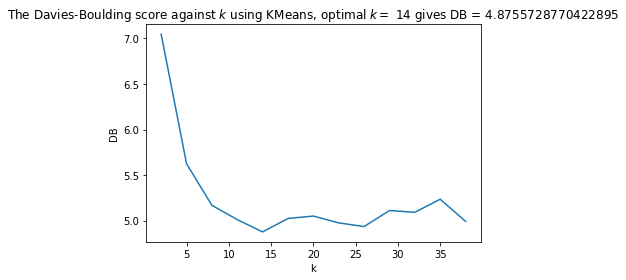

[143, 130, 1068, 388, 153, 82, 80, 104, 110, 166, 171, 150, 86, 204]
1257 - I have asked Secretary of State @SecPompeo to closely study the South Africa land and farm seizures and expropriations and the large scale killing of farmers. “South African Government is now seizing land from white farmers.” @TuckerCarlson @FoxNews
561 - Congresswoman @cathymcmorris of Washington State is an incredible leader who is respected by everyone in Congress. We need her badly in D.C. to keep building on #MAGA. She has my Strong Endorsement!
770 - People have no idea how hard Hurricane Michael has hit the great state of Georgia. I will be visiting both Florida and Georgia early next week. We are working very hard on every area and every state that was hit - we are with you!
1251 - I have authorized an emergency disaster declaration to provide Hawaii the necessary support ahead of #HurricaneLane. Our teams are closely coordinating with the state and local authorities. You are in our thoughts! https://t.

In [10]:
reduced = get_pca(20)

# apply the KMeans algorithm to the reduced data for different values of K
K = range(2,40,3)
DB = np.zeros_like(K).astype(float)
for i, k in enumerate(K):
    kmeans = KMeans(n_clusters = k, random_state=73).fit(reduced)
    with np.errstate(divide='ignore'):
        DB[i] = davies_bouldin_score(mat, kmeans.labels_)
k_opt = K[np.argmin(DB)]
plt.plot(K,DB)
plt.xlabel('k')
plt.ylabel('DB')
plt.title(f'The Davies-Boulding score against $k$ using KMeans, optimal $k = $ {k_opt} gives DB = {np.min(DB)}')
plt.show()


kmeans = KMeans(n_clusters = k_opt, random_state=73).fit(reduced)
sk_clusters = [[] for i in range(max(kmeans.labels_+1))]
for idx, lbl in enumerate(kmeans.labels_):
    sk_clusters[lbl].append(idx)
    
print(list(map(len, sk_clusters)))



random.seed(52345234)
# take some random tweets from every cluster
for cluster in sk_clusters:
    some_tweet_idx = random.sample(cluster, 5)
    for idx in some_tweet_idx:
        print(str(idx) + " - " + text_tweets["text"][idx])
    print("-"*40)

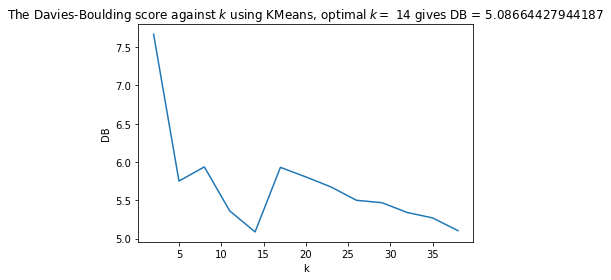

[190, 1196, 336, 132, 146, 199, 131, 190, 76, 137, 144, 89, 32, 37]
1585 - China is targeting our farmers, who they know I love &amp; respect, as a way of getting me to continue allowing them to take advantage of the U.S. They are being vicious in what will be their failed attempt. We were being nice - until now! China made $517 Billion on us last year.
1830 - ....We are getting other countries to reduce and eliminate tariffs and trade barriers that have been unfairly used for years against our farmers, workers and companies. We are opening up closed markets and expanding our footprint. They must play fair or they will pay tariffs!
1606 - The Amazon Washington Post has gone crazy against me ever since they lost the Internet Tax Case in the U.S. Supreme Court two months ago. Next up is the U.S. Post Office which they use, at a fraction of real cost, as their “delivery boy” for a BIG percentage of their packages....
2084 - The U.S. has made such bad trade deals over so many years that we

In [12]:
reduced = get_pca(20)
# apply 

# apply agglomerative clustering to the reduced data for different values of k (n_clusters)
K = range(2,40,3)
DB = np.zeros_like(K).astype(float)
i = 0
for k in K:
    kmeans = AgglomerativeClustering(n_clusters = k).fit(reduced)
    with np.errstate(divide='ignore'):
        DB[i] = davies_bouldin_score(mat, kmeans.labels_)
    i += 1
k_opt = K[np.argmin(DB)]
plt.plot(K,DB)
plt.xlabel('k')
plt.ylabel('DB')
plt.title(f'The Davies-Boulding score against $k$ using Agglomerative Clustering, optimal $k = $ {k_opt} gives DB = {np.min(DB)}')
plt.show()

agg = AgglomerativeClustering(n_clusters=k_opt).fit(reduced)
agg_clusters = [[] for i in range(max(agg.labels_+1))]
for idx, lbl in enumerate(agg.labels_):
    agg_clusters[lbl].append(idx)

print(list(map(len, agg_clusters)))

random.seed(162323)
# take some random tweets from every cluster
for k, cluster in enumerate(agg_clusters):
    some_tweet_idx = random.sample(cluster, 5)
    for idx in some_tweet_idx:
        print(str(idx) + " - " + text_tweets["text"][idx])
    print("-"*40)

In [13]:
for ncomps in range(5, 21):
    # use PCA to reduce the dimension
    reduced = get_pca(ncomps)
    # apply the DBSCAN algorithm to the reduced data
    dbscan = DBSCAN().fit(reduced)
    dbscan_clusters = [[] for i in range(max(dbscan.labels_+1))]
    for idx, lbl in enumerate(dbscan.labels_):
        dbscan_clusters[lbl].append(idx)

    sizes = list(map(len, dbscan_clusters))
    print(f"Using {ncomps} PCA comps, got {len(dbscan_clusters)} clusters")
    print(f"Cluster size has std dev {math.sqrt(np.var(sizes))}")

Using 5 PCA comps, got 1 clusters
Cluster size has std dev 0.0
Using 6 PCA comps, got 7 clusters
Cluster size has std dev 908.5935531897412
Using 7 PCA comps, got 11 clusters
Cluster size has std dev 695.0778183439024
Using 8 PCA comps, got 14 clusters
Cluster size has std dev 577.9001617397035
Using 9 PCA comps, got 15 clusters
Cluster size has std dev 531.047853043605
Using 10 PCA comps, got 14 clusters
Cluster size has std dev 528.0810514862046
Using 11 PCA comps, got 15 clusters
Cluster size has std dev 431.5449249176987
Using 12 PCA comps, got 14 clusters
Cluster size has std dev 461.19490434730346
Using 13 PCA comps, got 15 clusters
Cluster size has std dev 456.37362860806155
Using 14 PCA comps, got 12 clusters
Cluster size has std dev 512.0425532989312
Using 15 PCA comps, got 13 clusters
Cluster size has std dev 505.66477423815616
Using 16 PCA comps, got 12 clusters
Cluster size has std dev 535.9487628392185
Using 17 PCA comps, got 13 clusters
Cluster size has std dev 530.974954

In [14]:
# from the prints above, this should give a "small" number
# of clusters while also mantaining them as evenly sized as possible
reduced = get_pca(11)
# apply the DBSCAN algorithm to the reduced data
dbscan = DBSCAN().fit(reduced)
dbscan_clusters = [[] for i in range(max(dbscan.labels_+1))]
for idx, lbl in enumerate(dbscan.labels_):
    dbscan_clusters[lbl].append(idx)

random.seed(345234)
# take some random tweets from every cluster
for cluster in dbscan_clusters:
    some_tweet_idx = random.sample(cluster, min(5, len(cluster)))
    for idx in some_tweet_idx:
        print(str(idx) + " - " + text_tweets["text"][idx])
    print("-"*40)

2135 - Why aren’t the 13 Angry and heavily conflicted Democrats investigating the totally Crooked Campaign of totally Crooked Hillary Clinton. It’s a Rigged Witch Hunt, that’s why! Ask them if they enjoyed her after election celebration!
1370 - Strzok started the illegal Rigged Witch Hunt - why isn’t this so-called “probe” ended immediately? Why aren’t these angry and conflicted Democrats instead looking at Crooked Hillary?
1802 - Lover FBI Agent Peter Strzok was given poor marks on yesterday’s closed door testimony and, according to most reports, refused to answer many questions. There was no Collusion and the Witch Hunt, headed by 13 Angry Democrats and others who are totally conflicted, is Rigged!
1299 - No Collusion and No Obstruction, except by Crooked Hillary and the Democrats. All of the resignations and corruption, yet heavily conflicted Bob Mueller refuses to even look in that direction. What about the Brennan, Comey, McCabe, Strzok lies to Congress, or Crooked’s Emails!
11 - 

<h1>Different one-hot encoding</h1>

In [16]:
# create the one-hot encoding of each tweet
# start by fixing some ordering of the words
orderedWords = uniqueWords.keys()
matPrime = []
for tweet in tweets:
    one_hot_enc = []
    for word in orderedWords:
        one_hot_enc.append(1 if word in tweet else 0) # most of these will be 0s
    matPrime.append(one_hot_enc)

In [17]:
# get a more time-efficient (but more memory-consuming) way of retrieving
# the different PCAs, for different numbers of components:
def get_pca_prime(n):
    cached = get_pca_prime.memory.get(n, None)
    if cached is not None:
        return cached
    else:
        pca = PCA(n_components = n, random_state=3534)
        reduced = pca.fit_transform(matPrime)
        get_pca_prime.memory[n] = reduced
        return reduced
get_pca_prime.memory = dict()

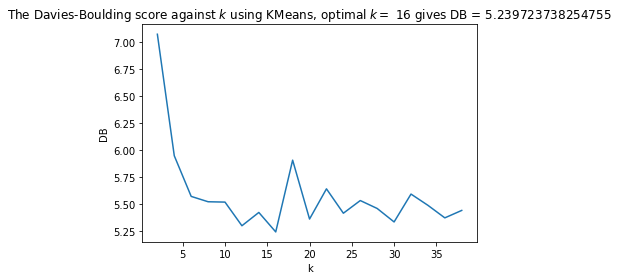

[228, 1245, 93, 188, 281, 186, 570, 244]
1055 - The White House is running beautifully. We are making some of the greatest and most important deals in our countries history - with many more to come. Big progress!
326 - Migrants at the Southern Border will not be allowed into the United States until their claims are individually approved in court. We only will allow those who come into our Country legally. Other than that our very strong policy is Catch and Detain. No “Releasing” into the U.S...
2997 - Yesterday was another big day for jobs and the Stock Market. Chrysler coming back to U.S. (Michigan) from Mexico and many more companies paying out Tax Cut money to employees. If Dems won in November, Market would have TANKED! It was headed for disaster.
531 - Just had a long and very good conversation with President Xi Jinping of China. We talked about many subjects, with a heavy emphasis on Trade. Those discussions are moving along nicely with meetings being scheduled at the G-20 in Arg

In [20]:
reduced = get_pca_prime(20)
# apply the KMeans algorithm to the reduced data

# apply KMeans to the reduced data for different values of k (n_clusters)
K = range(2,40,2)
DB = np.zeros_like(K).astype(float)
i = 0
for k in K:
    kmeans = KMeans(n_clusters = k).fit(reduced)
    with np.errstate(divide='ignore'):
        DB[i] = davies_bouldin_score(mat, kmeans.labels_)
    i += 1
k_opt = K[np.argmin(DB)]
plt.plot(K,DB)
plt.xlabel('k')
plt.ylabel('DB')
plt.title(f'The Davies-Boulding score against $k$ using KMeans, optimal $k = $ {k_opt} gives DB = {np.min(DB)}')
plt.show()

kmeans = KMeans(random_state=73).fit(reduced)
sk_clusters = [[] for i in range(max(kmeans.labels_+1))]
for idx, lbl in enumerate(kmeans.labels_):
    sk_clusters[lbl].append(idx)
    
print(list(map(len, sk_clusters)))

random.seed(52345234)
# take some random tweets from every cluster
for cluster in sk_clusters:
    some_tweet_idx = random.sample(cluster, 5)
    for idx in some_tweet_idx:
        print(str(idx) + " - " + text_tweets["text"][idx])
    print("-"*40)